In [1]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
%matplotlib inline

In [2]:
# dataset1 contains validation dataset from data1 and data2
# dataset2 contains validation dateaset from data3
all_detections1 = pickle.load( open( "/mnt/ml-data1/stage2/dataset1/detections.pkl", "rb" ) )
all_detections2 = pickle.load( open( "/mnt/ml-data1/stage2/dataset2/detections.pkl", "rb" ) )
detection_df1 = pd.DataFrame([ {'vid': d[0].split('-')[0].split('/')[-1], 'fid': int(d[0].split('-')[1].split('.')[0]), 'detections': d[1]} for d in all_detections1])
detection_df2 = pd.DataFrame([ {'vid': d[0].split('-')[0].split('/')[-1], 'fid': int(d[0].split('-')[1].split('.')[0]), 'detections': d[1]} for d in all_detections2])

In [3]:
real_starts_df1 = pd.read_csv('/mnt/ml-data1/stage2/dataset1/failure_starts.csv', index_col=0, names=['start'])
real_starts_df2 = pd.read_csv('/mnt/ml-data1/stage2/dataset2/failure_starts.csv', index_col=0, names=['start'])

real_starts_df1.index = real_starts_df1.index.astype('int64')
real_starts_df1 = real_starts_df1.sort_index()
real_starts_df2.index = real_starts_df2.index.astype('int64')
real_starts_df2 = real_starts_df2.sort_index()

In [4]:
detection_df = detection_df1
real_starts_df = real_starts_df1
# real_starts_df = real_starts_df[real_starts_df.start > 50]

,vid,failure_start,failure_start2
0,107,12,NaN
1,121,2071,NaN
2,143,1620,NaN
3,159,241,NaN
4,184,81,NaN
5,223,612,NaN
6,320,170,NaN
7,324,65,NaN
8,334,376,NaN
9,397,53,NaN


In [ ]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    if len(a) > n :
        ret[n:] = ret[n:] - ret[:-n]
        ret[n:] = ret[n:]/n
    for i in range(1,min(len(a),n)):
        ret[i] = ret[i]/(i+1)
    
    return ret

In [5]:
import os.path
#plt.rcParams['figure.figsize'] = [30, 15]

def draw_detection(vid, fid,threshold, ax=None) :
    #plt.rcParams['figure.figsize'] = [10, 5]
    boxes = detections[vid,fid,:,:].reshape(-1,5)
    boxes = boxes[boxes[:,0]>threshold]
    
    vid = real_starts_df.index[vid]
    fid = str(fid+1)
    filename = '/mnt/ml-data1/validation/videos3/jpgs/'+str(vid)+'-'+'0'*(5-len(fid)) + fid +'.jpg'
    print(filename)

    if not os.path.isfile(filename) :
        print('can not find file ', filename)
        return
    
    im = np.array(Image.open(filename), dtype=np.uint8)
    
    # Create figure and axes
    if ax == None :
        fig,ax = plt.subplots(1)

    # Display the image
    ax.imshow(im)

    # Create a Rectangle patch
    print('find boxes : ', boxes.shape[0])
    for b in boxes:
        print (b)
        rect = patches.Rectangle((b[1],b[2]),b[3],b[4],linewidth=1,edgecolor='r',facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)
        ax.text(b[1], b[2], '%.2f' % (b[0]),horizontalalignment='left',verticalalignment='top') #, fontsize=24)
   

In [10]:
# plot kmean and sum of probabilty average 
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

scaler = StandardScaler()

boxes_to_check = 5
kmean_samples = 50
kmean_clusters = 5
step = 10
kmean_history = np.zeros((len(real_starts_df),19603))
probability_history = np.zeros((len(real_starts_df),19603))
average_window = 10
dataset = []
label = []
frame_starts = []
for vid in range(len(real_starts_df)) :
    print("working on video ",  real_starts_df.index[vid])
    frame_starts.append(frame)
    fault_frame = failstart[vid]
    if fault_frame == 0 : 
        fault_frame == 1
        
    draw_detection(vid,fault_frame,0)
    plt.show()
    
    # dynamically adjust step size
    step = int(frame_size[vid]/100)
    step = max(step,1)
    step = min(step,10)
    print('total frames ', frame_size[vid], ' using step size ', step)
    if frame_size[vid]==0 :
        print('error: 0 total frame')
        continue
    
    for i in range(0,frame_size[vid],step) :
        if i%100 == 0 :
            print('.',end="")
        if i<10 : 
            continue
        
        frame += 1
        training_frames = detections[vid,np.random.choice(int(i*0.5),min(int(i*0.5),kmean_samples)),0:boxes_to_check,:].reshape(-1,5)
        scaler.fit(training_frames)
        s_frames = scaler.transform(training_frames)

        kmeans = KMeans(n_clusters=kmean_clusters, random_state=0).fit(s_frames)
        test_frames = detections[vid,i,0:boxes_to_check,:].reshape(-1,5)
        kmean_score = kmeans.transform(scaler.transform(test_frames))
        dataset.append(np.concatenate((detections[vid,i,0:boxes_to_check,0],np.min(kmean_score,axis=1))))
        label.append(i>= fault_frame)
        distance = np.min(kmean_score)
        kmean_history[vid,i] = distance
        probability_history[vid,i] = np.sum(test_frames[:,0])

    kmean_plot = moving_average(kmean_history[vid,0:frame_size[vid]:step],n=average_window)
    prob_plot = moving_average(probability_history[vid,0:frame_size[vid]:step],n=average_window)
    plt.plot(np.arange(0,frame_size[vid],step), kmean_plot, 'r')
    plt.plot(np.arange(0,frame_size[vid],step), prob_plot, 'b')
    max_y = max(np.max(kmean_plot), np.max(prob_plot))
    
    plt.plot([fault_frame-1, fault_frame-1], [0, max_y], color='k', linestyle='-', linewidth=2) 
    plt.legend(['kmean', 'prob', 'fault'], loc='best')
    plt.show()
    

working on video  824365


NameError: name 'draw_detection' is not defined

In [6]:
def sum_above_threshold(dets, threshold=0.25):
    return sum([d[1] for d in dets if d[1] > threshold])

def p_of_dets(dets):
    return [d[1] for d in dets[:20]]

def dataset_from_df(df, failure_start, with_head_avg=False, continuous_frames=5, boxes_to_check=2): 
    dataset = []
    label = []

    accu_p = df.detections.apply(sum_above_threshold).values
    head_avg = np.mean(accu_p[:10])
    p_s = np.array(df.detections.apply(p_of_dets).values.tolist())

    for i in range(continuous_frames, accu_p.shape[0]):
        label += [i >= failure_start]
        if with_head_avg:
            dataset += [[head_avg] + accu_p[i-continuous_frames:i].tolist()]      
        else:
            dataset += [p_s[i-continuous_frames:i, :boxes_to_check].reshape(-1).tolist()]

    return (dataset, label)

def video_detect(X_input, true_y):
    plt.rcParams['figure.figsize'] = [40, 5]
    y_pred = model.predict_proba(np.array(X_input))
    detection_threshold  = 0.78
    repeat_fails = 3
    plot = False

    fail_start_frame = len(list(filter(lambda x: not x, true_y)))
    
    if plot:
        figure =plt.figure()
        plt.subplot(121)
        plt.plot(true_y, 'r')
        plt.plot(y_pred[:,1], 'b')

    detection_frames = np.where(y_pred[:,1] > detection_threshold)[0]

    if plot:
        if len(detection_frames) >= repeat_fails : 
            plt.plot([detection_frames[repeat_fails-1],detection_frames[repeat_fails-1]],[0,1], linestyle='-', color='y')

#         ax=plt.subplot(122)
#         draw_detection(i,failstart[i],0,ax)
#         plt.show()

    if len(detection_frames) < repeat_fails : 
        # no detection
        if  fail_start_frame < 1e10 :
            print('False Negative')
            return 'fn'
        else :
            print('True Negative')
            return 'tn'
    elif detection_frames[repeat_fails-1] < fail_start_frame:
        print('False Positive')
        return 'fp'
    else :
        print('True Positive')
        return 'tp'

In [7]:
dataset = []
label = []
for vid, group in detection_df.groupby(['vid']):
    if vid not in real_starts_df.index.map(str):
        continue
    failure_start = real_starts_df.loc[int(vid)].start
#     (ds, l) = dataset_from_df(group, failure_start, with_head_avg=True, continuous_frames=10)
    (ds, l) = dataset_from_df(group, failure_start, with_head_avg=False)
    dataset += ds
    label += l

In [8]:
X = np.array(dataset)
y = np.array(label)
print(X.shape)
train_samples = int(X.shape[0] * 0.8)
X_train = X[:train_samples,:]
y_train = y[:train_samples]
X_test = X[train_samples:,:]
y_test = y[train_samples:]

(502531, 10)


In [9]:
from sklearn.linear_model import LogisticRegression
model =  LogisticRegression(random_state=0)
model.fit(X_train, y_train)
y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [16]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

model = XGBClassifier(max_depth=2, n_estimators=50)
model.fit(X_train, y_train)

y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

In [ ]:
import xgboost
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
xgb_model = xgboost.XGBClassifier()
model = GridSearchCV(xgb_model,
                   {'max_depth': [2,4,6],
                    'n_estimators': [50,100,200]}, verbose=1)
model.fit(X_train,y_train)
print(clf.best_score_)
print(clf.best_params_)
y_test_pred = model.predict_proba(X_test)
y_train_pred = model.predict_proba(X_train)

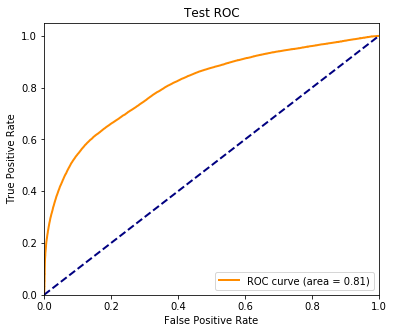

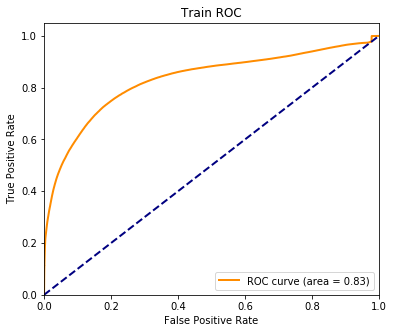

In [10]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_test, y_test_pred[:,1])
#fpr, tpr, _ = roc_curve(y_test, y_test_pred)

test_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test ROC')
plt.legend(loc="lower right")
plt.show()


fpr, tpr, _ = roc_curve(y_train, y_train_pred[:,1])
#fpr, tpr, _ = roc_curve(y_train, y_train_pred)

train_roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Train ROC')
plt.legend(loc="lower right")
plt.show()

In [11]:
stats = dict(fn=0, fp=0, tp=0, tn=0)
for vid, group in detection_df.groupby(['vid']):
    if vid not in real_starts_df.index.map(str):
        continue
    failure_start = real_starts_df.loc[int(vid)].start
#     (ds, l) = dataset_from_df(group, failure_start, with_head_avg=True, continuous_frames=10)
    (ds, l) = dataset_from_df(group, failure_start, with_head_avg=False)
    stats[video_detect(ds, l)] += 1

print(stats)
recall = stats['tp']/(stats['tp'] + stats['fn'])
precision=  stats['tp']/(stats['tp'] + stats['fp'])
f1 = 2*(recall*precision/(recall+precision))
print( 'f1=', f1, 'recall=', stats['tp']/(stats['tp'] + stats['fn']), 'precision=', stats['tp']/(stats['tp'] + stats['fp']) )

False Positive
False Negative
False Negative
True Positive
False Negative
False Negative
False Negative
True Positive
True Positive
True Positive
False Positive
False Positive
False Positive
False Negative
False Positive
False Negative
False Negative
True Positive
True Positive
True Positive
True Positive
True Positive
True Positive
False Negative
False Negative
False Negative
False Negative
True Positive
False Negative
False Negative
True Positive
False Negative
False Positive
True Positive
False Negative
True Positive
False Negative
True Positive
False Positive
True Positive
False Negative
True Positive
True Positive
False Positive
False Positive
False Positive
False Positive
True Positive
False Negative
True Positive
False Positive
False Positive
True Positive
True Positive
True Positive
True Positive
False Positive
True Positive
False Positive
True Positive
False Negative
False Positive
False Negative
False Positive
False Positive
True Positive
True Positive
True Positive
False Neg

In [26]:
# build dataset with averages of past [1, 10, 20, 50, 100] frames
def get_avg(vid, fid, n, boxes) :
    if fid == 0 :
        return detections[vid,fid,:boxes,0]
    if fid >= n-1 :
        window = detections[vid,fid-n+1: fid+1,:boxes,0]
    else :
        window = detections[vid,:fid+1, :boxes, 0]
    return (np.sum(window, axis=0)/window.shape[0]).reshape(-1)

dataset = []
label = []
frame = 0
frame_starts = []
kmean_samples = 50
kmean_clusters = 5
boxes_to_check = 5
for vid in range(len(real_starts_df)) :
    print("working on video ",  real_starts_df.index[vid])
    step = max( 1, int(frame_size[vid]/100))
    print('step = ', step)
    frame_starts.append(frame)
    for fid in range(0,frame_size[vid],step) :
        feature = detections[vid,fid, :boxes_to_check, 0].reshape(-1)
        for n in [10, 20, 50, 100] :
            feature = np.concatenate((feature, get_avg(vid,fid,n,boxes_to_check)))
        dataset.append(feature)           
        label.append(fid >= failstart[vid])
        frame +=1



working on video  190011


NameError: name 'frame_size' is not defined

In [58]:
#LSTM model 
from keras.models import Sequential
from keras.layers import LSTM, Dense, TimeDistributed
from keras.utils import to_categorical
import numpy as np

model = Sequential()

# input is n boxes, a total of 5 x n features
boxes_to_check = 5
model.add(LSTM(32, return_sequences=True, input_shape=(None, 5 * boxes_to_check)))
model.add(LSTM(8, return_sequences=True))
model.add(TimeDistributed(Dense(1, activation='sigmoid')))

print(model.summary())

model.compile(loss='binary_crossentropy',
              optimizer='adam')

def train_generator():
    # return one video at each call
    num_videos = int(len(real_starts_df) * 0.8)
    vid = 0
    step = 10
    while True:
        sequence_length = frame_size[vid]
        if sequence_length == 0 :
            vid+= 1
            vid = vid % num_videos
            continue
                    
        x_train = detections[vid,0:sequence_length:step,:boxes_to_check,:].reshape(1, -1,boxes_to_check*5)
        y_train = np.arange(0,sequence_length,step)
        y_train = (y_train>= failstart[vid]).reshape(1,-1,1)
        #print(x_train.shape,y_train.shape)
        vid += 1
        vid = vid % num_videos
        yield x_train, y_train
def validate_generator():
    
    # return one video at each call
    num_videos_start = int(len(real_starts_df) * 0.8)
    num_videos = len(real_starts_df) - num_videos_start
    vid = 0
    step = 10
    while True:
        this_vid = vid + num_videos_start
        sequence_length = frame_size[this_vid]
        if sequence_length == 0 :
            vid+= 1
            vid = vid % num_videos
            continue
                    
        x_train = detections[this_vid,0:sequence_length:step,:boxes_to_check,:].reshape(1, -1,boxes_to_check*5)
        y_train = np.arange(0,sequence_length, step)
        y_train = (y_train>= failstart[this_vid]).reshape(1,-1,1)
        vid += 1
        vid = vid % num_videos
        yield x_train, y_train 
        
def validate_generator2():
    # return one video at each call
    sequence_length = 50
    batch_size = 15
    num_videos = len(real_starts_df)
    validation_videos_start = int(len(real_starts_df)*0.8)
    while True:
        x_batch = []
        y_batch = []
        for i in range(batch_size) :
            while True :
                vid = np.random.randint(validation_videos_start, num_videos)
                if failstart[vid] > sequence_length and failstart[vid] < frame_size[vid] :
                    break
            # pick one from each category for balanced training
            fid = np.random.randint(sequence_length,failstart[vid])
            x_train = detections[vid,fid-sequence_length+1:fid+1,:boxes_to_check,:].reshape(sequence_length,boxes_to_check*5)
            y_train = np.arange(fid-sequence_length+1, fid+1)
            y_train = (y_train>= failstart[vid]).reshape(sequence_length,1)
            x_batch.append(x_train)
            y_batch.append(y_train)
            
            fid = np.random.randint(failstart[vid], frame_size[vid])
            x_train = detections[vid,fid-sequence_length+1:fid+1,:boxes_to_check,:].reshape(sequence_length,boxes_to_check*5)
            y_train = np.arange(fid-sequence_length+1, fid+1)
            y_train = (y_train>= failstart[vid]).reshape(sequence_length,1)
            x_batch.append(x_train)
            y_batch.append(y_train)
        
        x_batch = np.stack(x_batch,axis=0)    
        y_batch = np.stack(y_batch,axis=0)
        
        yield x_batch, y_batch
        
model.fit_generator(generator = train_generator(), steps_per_epoch=int(len(real_starts_df)*0.8),
                    validation_data = validate_generator(), 
                    validation_steps =len(real_starts_df) - int(len(real_starts_df)*0.8), 
                    epochs=1, verbose=1)


/anaconda/envs/py35/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, None, 32)          7424      
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 8)           1312      
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1)           9         
Total params: 8,745
Trainable params: 8,745
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/1
227/227 [==============================] - 103s 453ms/step - loss: 0.6933 - val_loss: 0.6826


In [59]:
y_train = []
y_train_pred = []
count = 0
for x,y in train_generator() :
    y_pred = model.predict(x)
    y_train.append(y.ravel())
    y_train_pred.append(y_pred.ravel())
    count += 1
    if count == 226 :
        break
y_train = np.concatenate(y_train)
y_train_pred = np.concatenate(y_train_pred)

y_test = []
y_test_pred = []
count = 0
for x,y in validate_generator() :
    y_pred = model.predict(x)
    y_test.append(y.ravel())
    y_test_pred.append(y_pred.ravel())
    count += 1
    if count == 284-227 :
        break
y_test = np.concatenate(y_test)
y_test_pred = np.concatenate(y_test_pred)